
# Fine Tuning



## Preparação dos Dados

In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [5]:
caminho_arquivo = '/content/drive/MyDrive/JBCS/Anotações/anotadores-sexismo - anotadores-sexismo.csv'
df = pd.read_csv(caminho_arquivo)

In [6]:
df.head()

,Id,Frase,Categoria 1,Categoria 2,Categoria 3,Categoria 4,Categoria 5,Sexismo,Resultado
0,1,ela é muito sensual,Sexismo Hostil,Sexismo Benevolente,Sexismo Hostil,Sexismo Hostil,Sexismo Hostil,Sexismo Hostil,Sexismo Hostil
1,2,menina bela,Não contém,Não contém,Não contém,Não contém,Não categorizado,Não contém,Não contém
2,4,ela é linda,Não contém,Não contém,Não contém,Não contém,Não contém,Não contém,Não contém
3,6,ela é mulher,Não contém,Não contém,Não contém,Não contém,Não contém,Não contém,Não contém
4,24,"mulher, menina",Não contém,Não contém,Indeterminado,Não contém,Não contém,Não contém,Não contém


In [7]:
df.shape

(2375, 9)

In [8]:
df = df[df['Resultado'].notna()]

In [9]:
categoria_counts = df['Resultado'].value_counts()
print(categoria_counts)

Resultado
Não contém             1622
Sexismo Hostil          547
Sexismo Benevolente     206
Name: count, dtype: int64


In [10]:
X = df['Frase'].values  # Frases
y = df['Resultado'].values  # Rótulos

In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Resultado'])

In [13]:
classes_mapeadas = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(classes_mapeadas)

{'Não contém': 0, 'Sexismo Benevolente': 1, 'Sexismo Hostil': 2}


In [14]:
from imblearn.over_sampling import RandomOverSampler

In [15]:
def balance_classes(X, y):
    ros = RandomOverSampler(random_state=42)
    X, y = ros.fit_resample(X.reshape(-1, 1), y)
    return X.flatten(), y

In [16]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW

In [17]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

## Treinamento

In [18]:
# treinamento
def train_model(model, data_loader, optimizer):
    model = model.train()
    total_loss = 0
    for batch in data_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    return total_loss / len(data_loader)

## Avaliação

In [19]:
# avaliação
from sklearn.metrics import classification_report

def evaluate_model(model, data_loader):
    model = model.eval()
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            total_correct += torch.sum(preds == labels)
            total_samples += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Gera o classification report
    class_report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_)

    return accuracy, precision, recall, f1, class_report, all_preds


In [20]:
# tokenizer e o modelo BERTimbau
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased')
model = BertForSequenceClassification.from_pretrained('neuralmind/bert-large-portuguese-cased', num_labels=3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-large-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validação Cruzada Estratificada


In [21]:
# Definir o número de folds para validação cruzada
n_splits = 10 #10 é o mais comum, mas pode aumentar o número de folds desde que contenha no minimo 30 exemplos em cada fold, ex: 100 exemplos anotados, deve ter no maximo 3 folds / Deve-se saber tbm, que quanto maior o número de folds, maior o custo computacional
skf = StratifiedKFold(n_splits=n_splits)

In [22]:
# Otimizador
optimizer = AdamW(model.parameters(), lr=1e-5)

In [23]:
all_fold_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

In [24]:
all_true_labels = []
all_pred_labels = []

## Treinamento e Avaliação de Modelo com Validação Cruzada Estratificada e Balanceamento de Classes

In [26]:
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {fold+1}/{n_splits}")

    # Dividir os dados em treino e teste
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Balancear as classes no conjunto de treino
    X_train_balanced, y_train_balanced = balance_classes(X_train, y_train)

    # Criar datasets e dataloaders
    train_dataset = TextDataset(X_train_balanced, y_train_balanced, tokenizer)
    test_dataset = TextDataset(X_test, y_test, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # mini-batch de tamanho 16 e shuffle para pegar amostras aleatórias
    test_loader = DataLoader(test_dataset, batch_size=16) # mini-batch de tamanho 16

    # Treinar o modelo no fold atual
    train_loss = train_model(model, train_loader, optimizer)
    print(f"Loss de treino no Fold {fold+1}: {train_loss}") #quanto menor a loss em cada fold significa que o modelo está aprendendo

    # Avaliar o modelo no fold atual
    accuracy, precision, recall, f1, class_report, all_preds = evaluate_model(model, test_loader)
    #print(f"Acurácia no Fold {fold+1}: {accuracy}")
    #print(f"Precisão no Fold {fold+1}: {precision}")
    #print(f"Recall no Fold {fold+1}: {recall}")
    #print(f"F1-score no Fold {fold+1}: {f1}")
    #print(f"Classification Report no Fold {fold+1}:\n{class_report}")

    # Armazenar métricas para cada fold
    all_fold_metrics['accuracy'].append(accuracy)
    all_fold_metrics['precision'].append(precision)
    all_fold_metrics['recall'].append(recall)
    all_fold_metrics['f1'].append(f1)

    all_true_labels.extend(y_test)
    all_pred_labels.extend(all_preds)

# Cálculo das métricas finais (médias)
final_accuracy = np.mean(all_fold_metrics['accuracy'])
final_precision = np.mean(all_fold_metrics['precision'])
final_recall = np.mean(all_fold_metrics['recall'])
final_f1 = np.mean(all_fold_metrics['f1'])


print(f"\nDesempenho Final:")
print(f"Accuracy Média: {final_accuracy}")
print(f"Precision Média: {final_precision}")
print(f"Recall Médio: {final_recall}")
print(f"F1-score Médio: {final_f1}")

# Geração do Classification Report geral
final_class_report = classification_report(all_true_labels, all_pred_labels, target_names=label_encoder.classes_)
print("\nClassification Report:")
print(final_class_report)

Fold 1/10
Loss de treino no Fold 1: 0.2391668957909637
Fold 2/10
Loss de treino no Fold 2: 0.1207599585270849
Fold 3/10
Loss de treino no Fold 3: 0.07955558219054429
Fold 4/10
Loss de treino no Fold 4: 0.06628507793112828
Fold 5/10
Loss de treino no Fold 5: 0.038486400303893116
Fold 6/10
Loss de treino no Fold 6: 0.039263001607007
Fold 7/10
Loss de treino no Fold 7: 0.0371945121119064
Fold 8/10
Loss de treino no Fold 8: 0.028243879710509352
Fold 9/10
Loss de treino no Fold 9: 0.02621031443190754
Fold 10/10
Loss de treino no Fold 10: 0.02389827295536614

Desempenho Final:
Accuracy Média: 0.9025877324462583
Precision Média: 0.9591505306151817
Recall Médio: 0.9025877324462583
F1-score Médio: 0.9098427306840258

Classification Report:
                     precision    recall  f1-score   support

         Não contém       0.99      0.88      0.93      1784
Sexismo Benevolente       0.51      0.95      0.66       227
     Sexismo Hostil       0.94      0.96      0.95       602

           ac

# Sem Fine Tuning

In [29]:
from transformers import BertTokenizer, BertModel
import numpy as np

tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased')
model = BertModel.from_pretrained('neuralmind/bert-large-portuguese-cased')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [27]:
def get_embeddings(texts, tokenizer, model, max_length=128):
    model.eval()  # Colocar o modelo em modo de avaliação
    embeddings = []
    with torch.no_grad():  # Não calcular gradientes
        for text in texts:
            # Tokenização da frase
            inputs = tokenizer(
                text,
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            inputs = {key: value.to(device) for key, value in inputs.items()}

            # Obter as representações da última camada
            outputs = model(**inputs)
            embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())  # Pooling [CLS]
    return np.vstack(embeddings)  # Retorna um array 2D

In [30]:
X_train_embeddings = get_embeddings(X_train, tokenizer, model)
X_test_embeddings = get_embeddings(X_test, tokenizer, model)

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Treinar um classificador
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_embeddings, y_train)

# Fazer previsões
y_pred = clf.predict(X_test_embeddings)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("\nClassification Report:\n", class_report)

Accuracy: 0.8438818565400844
Precision: 0.8316294137987723
Recall: 0.8438818565400844
F1-score: 0.8337292454381062

Classification Report:
                      precision    recall  f1-score   support

         Não contém       0.90      0.93      0.92       162
Sexismo Benevolente       0.55      0.29      0.38        21
     Sexismo Hostil       0.74      0.80      0.77        54

           accuracy                           0.84       237
          macro avg       0.73      0.67      0.69       237
       weighted avg       0.83      0.84      0.83       237



# Comparação

In [32]:
import pandas as pd

comparison = {
    "Métrica": ["Accuracy", "Precision", "Recall", "F1-score"],
    "Sem Fine-Tuning": [accuracy, precision, recall, f1],
    "Com Fine-Tuning": [final_accuracy, final_precision, final_recall, final_f1]  # Valores do modelo com fine-tuning
}

df_comparison = pd.DataFrame(comparison)
print(df_comparison)

     Métrica  Sem Fine-Tuning  Com Fine-Tuning
0   Accuracy         0.843882         0.902588
1  Precision         0.831629         0.959151
2     Recall         0.843882         0.902588
3   F1-score         0.833729         0.909843


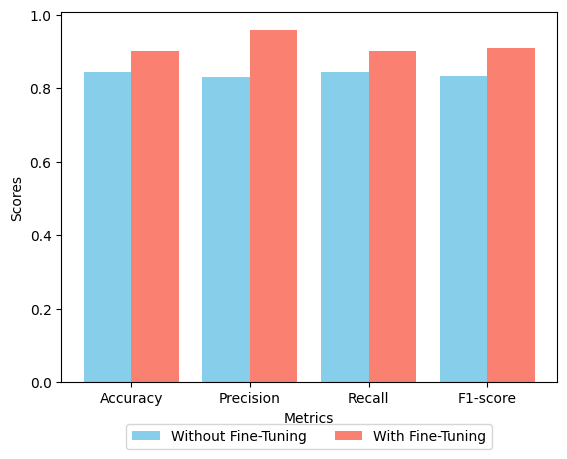

In [38]:
import matplotlib.pyplot as plt

labels = ["Accuracy", "Precision", "Recall", "F1-score"]
no_tuning = [accuracy, precision, recall, f1]
tuned = [final_accuracy, final_precision, final_recall, final_f1]

x = range(len(labels))
plt.bar(x, no_tuning, width=0.4, label='Without Fine-Tuning', align='center', color='skyblue')
plt.bar([p + 0.4 for p in x], tuned, width=0.4, label='With Fine-Tuning', align='center', color='salmon')
plt.xticks([p + 0.2 for p in x], labels)
plt.xlabel("Metrics")
plt.ylabel("Scores")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.show()
